In [70]:
# Import modules

%matplotlib notebook

#import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from obspy import UTCDateTime, read, read_inventory, read_events
from obspy.clients.fdsn import Client
from obspy.clients.fdsn.header import FDSNNoDataException
from datetime import datetime, timedelta, timezone

import pandas as pd
from scipy.interpolate import interp1d
import os
import shutil

from time import time
import pickle

In [71]:
# Define the data directories

cwd = os.getcwd()
data_dir = os.path.join(cwd, "data")
raw_waveform_dir = os.path.join(data_dir, "waveforms_raw")
processed_waveform_dir = os.path.join(data_dir, "waveforms_proc_broadband")

In [72]:
# Remove the old directories and create new ones

if os.path.isdir(raw_waveform_dir):
    shutil.rmtree(raw_waveform_dir)
os.mkdir(raw_waveform_dir)

if os.path.isdir(processed_waveform_dir):
    shutil.rmtree(processed_waveform_dir)
os.mkdir(processed_waveform_dir)

# Station inventory and event catalogue

First, we define the parameters for the data acquisition. We take the catalogue from the Southern California Seismic Network (`CI`) from 2000 to 2015, and select all seismic stations and events recorded within a latitude range of 32$^{\circ}$ to 36$^{\circ}$, and within a longitude range of -120$^{\circ}$ to -116$^{\circ}$.

In [73]:
# Parameters

client = Client("IRIS")
network = ["CN","UW"]  # Southern California Seismic Network

inventory_filename = "inventory.xml"
catalogue_filename = "catalogue.file"

starttime = UTCDateTime("2000-01-01T00:00:00")
endtime = UTCDateTime("2020-01-01T00:00:00")

station_settings = {
    "network": "UW,CN",
    "minlatitude": 41.0,
    "maxlatitude": 51.05,
    "minlongitude": -129.5,
    "maxlongitude": -116,
    "startbefore": endtime,
    "endafter": starttime,
    "level": "response",
    "filename": inventory_filename,
    "format": "xml",
    "channel": "BHN,BHE,BHZ",
}

event_settings = {
    "minlatitude": 41.0,
    "maxlatitude": 51.05,
    "minlongitude": -129.5,
    "maxlongitude": -116,
    "starttime": starttime,
    "endtime": endtime,
    "minmagnitude": 2.5,
    "filename": catalogue_filename,
}

In [74]:
# Get seismic stations (may take a few minutes)
client.get_stations(**station_settings)

We create a Pandas dataframe with some useful station metadata:

In [81]:
# Read the stations
station_df = pd.DataFrame(columns=("code", "lat", "lon", "start_date", "end_date", "network"))
for nw in network:
    #print(nw)
    stations = read_inventory(inventory_filename).select(network=nw)[0]
    # Get the station codes (sort alphabetically)
    station_codes = np.sort([station.code for station in stations])

    # Loop over sorted station codes
    for station_code in station_codes:
        # Select the station data
        station = stations.select(station=station_code)[0]
        # Append station metadata to dataframe
        station_df = station_df.append(
            {
                "code": station_code, 
                "lat": station.latitude, 
                "lon": station.longitude,
                "start_date": station.start_date,
                "end_date": station.end_date,
                "network" : nw
            }, ignore_index=True
        )

# Save dataframe to CSV
station_df.to_csv(os.path.join(data_dir, "stations.csv"), index=False)

In [82]:
station_df

,code,lat,lon,start_date,end_date,network
0,ATLB,50.218400,-127.060000,2005-04-21T00:00:00.000000Z,2006-09-12T23:59:59.000000Z,CN
1,BMSB,48.835600,-125.135500,2003-03-07T00:00:00.000000Z,2011-11-24T23:59:59.000000Z,CN
2,CBB,50.031500,-125.365200,1996-11-28T00:00:00.000000Z,None,CN
3,CPLB,48.611800,-124.751200,2004-04-21T00:00:00.000000Z,None,CN
4,EDB,49.873000,-127.121600,1982-04-29T00:00:00.000000Z,None,CN
...,...,...,...,...,...,...
77,UGP4,46.530231,-120.446373,2018-01-02T00:00:00.000000Z,2018-03-04T00:00:00.000000Z,UW
78,UMAT,45.290400,-118.959500,2008-12-02T00:00:00.000000Z,None,UW
79,WISH,47.116980,-123.771180,2004-04-20T00:00:00.000000Z,None,UW
80,WOLL,47.057301,-118.920998,2008-11-10T00:00:00.000000Z,None,UW


As a quick sanity check, we plot the station locations:

<IPython.core.display.Javascript object>


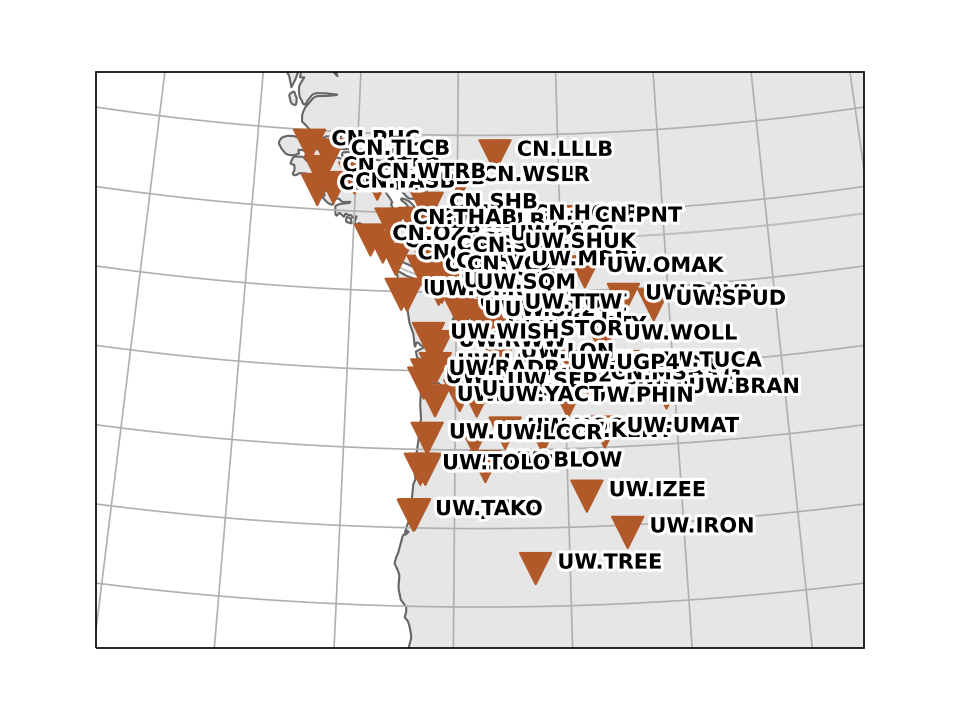

In [77]:
stations = read_inventory(inventory_filename)
# Plot station locations
pl = stations.plot(projection="local", resolution="i", show=True)
plt.show()

Next, we download the SCSN event catalogue:

In [78]:
client.get_events(**event_settings)

In [79]:
# Read events from file
catalogue = read_events(catalogue_filename)
print(catalogue)

7455 Event(s) in Catalog:
2019-12-31T17:13:50.820000Z | +48.595, -123.099 | 2.6 ML
2019-12-28T20:07:32.641000Z | +42.014, -126.170 | 2.7 ML
...
2000-01-02T11:53:12.930000Z | +48.311, -128.494 | 3.3 mb
2000-01-02T11:50:43.410000Z | +48.001, -129.033 | 2.8 mb
To see all events call 'print(CatalogObject.__str__(print_all=True))'


Again, we plot some events just to check everything went as expected:

<IPython.core.display.Javascript object>


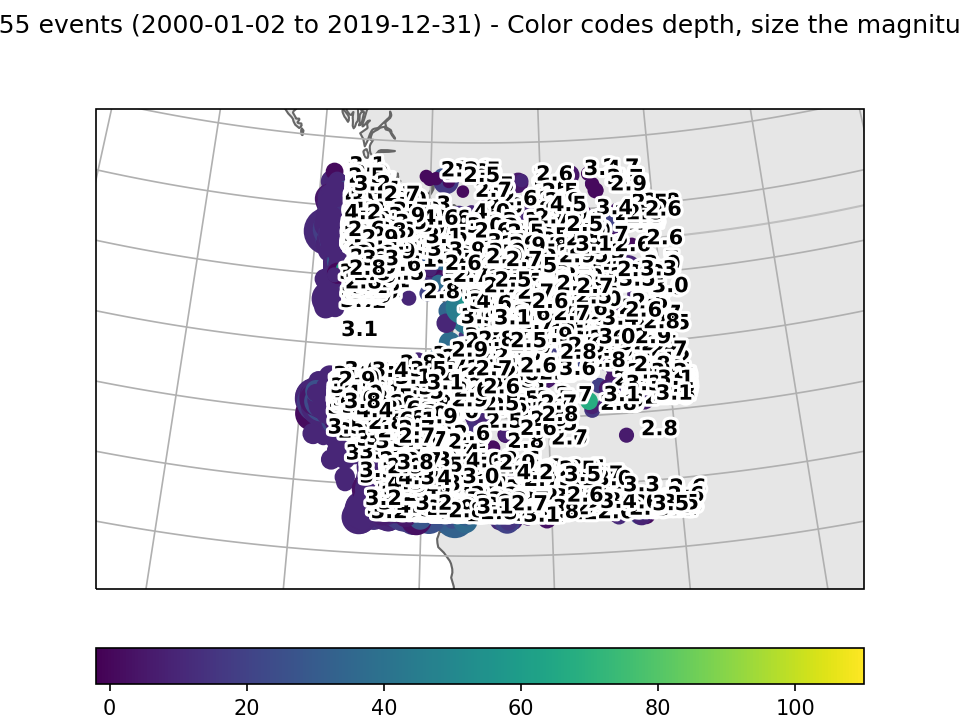

/home/lchuang/anaconda3/envs/gnn/lib/python3.7/site-packages/obspy/imaging/maps.py:765: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  format=formatter)


In [80]:
catalogue.plot(projection="local", resolution="i", show=True)
plt.show()

# Downloading the raw waveforms

In the cell below, we download the waveforms and create a lookup table for the stations that were operational at the time of the event. While looping over all events in the catalogue, we select the "preferred" origin time, location, and magnitude, and check which stations were operational around the origin time. We then download the three-component waveforms up to 120 seconds after the origin time for each operational station. 

**Note 1**: the "operational" stations have not necessarily recorded anything. We will do additional quality checking in a subsequent step.

**Note 2**: downloading the waveforms takes several hours with a fast internet connection.

In [89]:
# Initiate event catalogue dataframe
catalogue_df = pd.DataFrame(columns=("time", "lat", "lon", "depth", "mag"))
# Initiate station lookup table
catalogue_station_lookup = {}

t0 = time()
ETA = 0

# Loop over events in SCSN catalogue
for i, event in enumerate(catalogue):
    
    # Calculate ETA based on average processing time
    running_time = time() - t0
    events_per_sec = (i + 1) / running_time
    events_to_do = len(catalogue) - i
    ETA = events_to_do / events_per_sec
    
    print("Fetching event %d / %d [ETA: %.d s]" % (i+1, len(catalogue), ETA))
    
    # Check which event origin time/location and magnitude are preferred
    pref_origin = event.preferred_origin_id
    pref_magnitude = event.preferred_magnitude_id
    origins = event.origins
    magnitudes = event.magnitudes
    
    # Grab preferred origin
    for origin in origins:
        if origin.resource_id == pref_origin:
            break
    
    # Grab preferred magnitude
    for magnitude in magnitudes:
        if magnitude.resource_id == pref_magnitude:
            break
    
    # Append event to dataframe
    catalogue_df = catalogue_df.append(
        {"time": origin.time, "lat": origin.latitude, "lon": origin.longitude, "depth": origin.depth, "mag": magnitude.mag}, 
        ignore_index=True
    )
    
    # Waveform output file
    waveform_file = os.path.join(raw_waveform_dir, "%d.sac" % i)
    
    # Start and end time of waveforms
    start_trace = origin.time
    end_trace = origin.time + timedelta(seconds=120)
    
    # Check which stations were operational
    # Station commissioned before start time
    station_inds = (station_df["start_date"] < start_trace)
    # (and) station decommissioned after end time, or still operational
    station_inds = station_inds & ((station_df["end_date"] > end_trace) | station_df["end_date"].isnull())
    # Get station codes of operational stations
    operational_stations = station_df["code"][station_inds].values
    operational_stations_nw = station_df["network"][station_inds].values
    
    # Append operational stations to lookup table
    catalogue_station_lookup[i] = operational_stations
    
    # Generate query for requesting waveforms
    bulk_query = []
    for rr in range(len(operational_stations)):
        bulk_query.append((operational_stations_nw[rr],operational_stations[rr], "*", "BH*", start_trace, end_trace))
        
    print("Fetching data for %d stations" % len(operational_stations))
    
    # Get the data (if available) and write to output file
    try:
        client.get_waveforms_bulk(bulk_query, filename=waveform_file)
    # If FDSN complains: move on
    except FDSNNoDataException:
        print("No data...")
        continue

# Write event catalogue to CSV
catalogue_df.to_csv(os.path.join(data_dir, "catalogue.csv"))

# Write lookup table to binary object
lookup_file = os.path.join(data_dir, "catalogue_station_lookup.pickle")
with open(lookup_file, "wb") as f:
    pickle.dump(catalogue_station_lookup, f, protocol=pickle.HIGHEST_PROTOCOL)

Fetching event 1 / 7455 [ETA: 3 s]
Fetching data for 53 stations
Fetching event 2 / 7455 [ETA: 3421 s]
Fetching data for 53 stations
Fetching event 3 / 7455 [ETA: 6043 s]
Fetching data for 53 stations
Fetching event 4 / 7455 [ETA: 6536 s]
Fetching data for 53 stations
Fetching event 5 / 7455 [ETA: 6795 s]
Fetching data for 53 stations
Fetching event 6 / 7455 [ETA: 6727 s]
Fetching data for 53 stations
Fetching event 7 / 7455 [ETA: 7380 s]
Fetching data for 53 stations
Fetching event 8 / 7455 [ETA: 7392 s]
Fetching data for 53 stations
Fetching event 9 / 7455 [ETA: 7745 s]
Fetching data for 53 stations
Fetching event 10 / 7455 [ETA: 7698 s]
Fetching data for 53 stations
Fetching event 11 / 7455 [ETA: 7733 s]
Fetching data for 53 stations
Fetching event 12 / 7455 [ETA: 7724 s]
Fetching data for 53 stations
Fetching event 13 / 7455 [ETA: 7691 s]
Fetching data for 53 stations
Fetching event 14 / 7455 [ETA: 7845 s]
Fetching data for 53 stations
Fetching event 15 / 7455 [ETA: 8035 s]
Fetchin

KeyboardInterrupt: 

# Processing the waveforms

After downloading the raw waveforms, we pre-process them to serve as an input to the deep learning model. First we check for each station that its response is available. Then we filter the waveforms between 0.1 and 8 Hz and interpolate the data onto a common time base sampled at ~20 Hz.

**Note**: this again takes several hours

In [87]:
from obspy.core.util.obspy_types import ObsPyException

# Read in the event catalogue
catalogue_df = pd.read_csv(os.path.join(data_dir, "catalogue.csv"))
# Convert time to timestamp
catalogue_df["time"] = pd.to_datetime(catalogue_df["time"])

Ntrace = 3     # Number of waveform components
Nt = 2048      # Number of time elements
scale = 1e5    # Scaling factor for waveform amplitude

t0_ETA = time()
ETA = 0

# Buffer to event-station lookup table
catalogue_station_lookup_final = {}

# Loop over all events in the catalogue
for i, event in catalogue_df.iterrows():
    
    # Calculate ETA based on average processing time
    running_time = time() - t0_ETA
    events_per_sec = (i + 1) / running_time
    events_to_do = len(catalogue) - i
    ETA = events_to_do / events_per_sec
    
    print("Processing event %d / %d [ETA: %d s]" % (i+1, len(catalogue), ETA))
    
    # Define the raw waveform file
    event_file = os.path.join(raw_waveform_dir, "%d.sac" % i)
    # If the data file does not exist (due to FDSN error in previous step): skip
    if not os.path.isfile(event_file):
        print("Event %d not found" % (i + 1))
        continue
    
    # Select all operational stations
    operational_stations = catalogue_station_lookup[i]
    # Number of operational stations
    Nstations = len(operational_stations)
    
    # Read the waveforms from file
    data = read(event_file)
    
    # Create a common time base from 1 < t < 101 seconds after the origin time
    starttime = event["time"] + timedelta(seconds=1)
    endtime = starttime + timedelta(seconds=101)
    time_base = pd.date_range(starttime, endtime, periods=Nt).to_pydatetime()
    # Create time base to proper UTC time (including DST and such)
    timestamp_base = np.array([dt.replace(tzinfo=timezone.utc).timestamp() for dt in time_base])
    # Make time base relative to start time
    t0 = timestamp_base.min()
    t_int = timestamp_base - t0
    
    # Buffer for processed waveforms (default to NaN for later pruning)
    proc_data = np.zeros((Nstations, Nt, 3)) * np.nan
    
    # Loop over operational stations
    for k, station in enumerate(operational_stations):
        # Select data stream for current station
        stream = data.select(station=station)
        # Check if all 3 components are present (no more, no less)
        if len(stream) == Ntrace:
            # Subtract mean of the trace
            stream.detrend("simple") 
            # Check if we can remove the station response (doesn't always work)
            try:
                stream.remove_response(inventory=stations, zero_mean=True)
            # Sometimes the station response information is not available
            except ValueError:
                print("Response could not be removed")
                continue
            # Sometimes ObsPy throws a weird error
            except ObsPyException as e:
                print("Weird Obspy exception")
                continue
            # If everything went well, filter signals between 0.1 and 8 Hz
            stream.filter("bandpass", freqmin=0.1, freqmax=8.0, zerophase=True)
            # Loop over waveform components
            for n in range(Ntrace):
                # Extract component
                trace = stream[n]
                tr_data = trace.data
                # Subtract mean (just in case)
                tr_data -= tr_data.mean()
                # Multiply with arbitrary scale
                tr_data *= scale
                # Component time base
                t = trace.times(type="timestamp") - t0
                # Interpolate data onto common time base and store in buffer
                proc_data[k, :, n] = interp1d(t, tr_data, fill_value=0, bounds_error=False, assume_sorted=True)(t_int)
    
    # Check which stations have valid data (i.e. which rows in proc_data are not NaN)
    ok_inds = np.isfinite(proc_data[:, 0, 0])
    # Append the stations that have valid data to lookup table
    catalogue_station_lookup_final[i] = operational_stations[ok_inds]
    # Define processed waveform output file
    proc_data_file = os.path.join(processed_waveform_dir, "%d.npy" % i)
    # Write output file
    np.save(proc_data_file, proc_data[ok_inds])

# Write lookup table to disk
lookup_file = os.path.join(data_dir, "catalogue_station_lookup_final.pickle")
with open(lookup_file, "wb") as f:
    pickle.dump(catalogue_station_lookup_final, f, protocol=pickle.HIGHEST_PROTOCOL)

FileNotFoundError: [Errno 2] No such file or directory: '/home/lchuang/Projects/GNN/PC_VAN/data/catalogue.csv'

Plot the waveforms of the event with the largest magnitude as a quick check:

364 Unnamed: 0                                 364
time          2010-07-07 23:53:34.280000+00:00
lat                                    33.3809
lon                                  -116.5054
depth                                   7000.0
mag                                        5.5
Name: 364, dtype: object


<IPython.core.display.Javascript object>


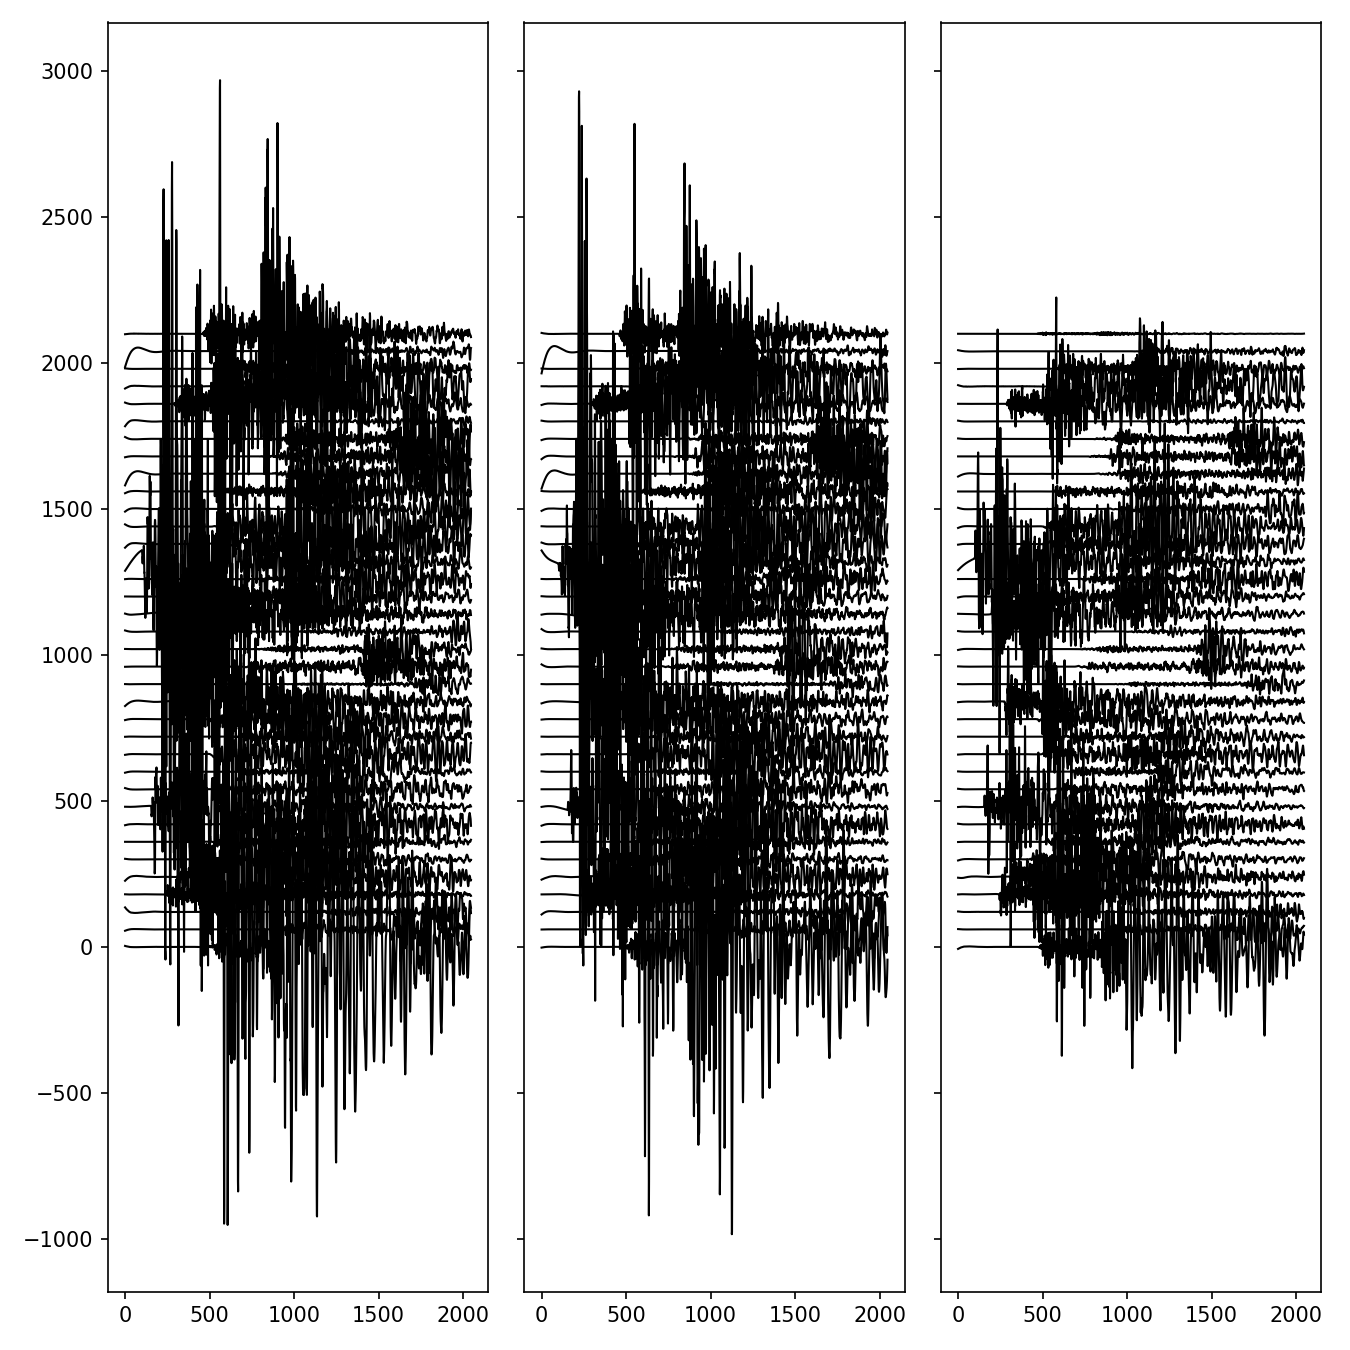

In [31]:
event_id = catalogue_df["mag"].idxmax()
print(event_id, catalogue_df.loc[event_id])
event_data = np.load(os.path.join(processed_waveform_dir, "%d.npy" % event_id))
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 9), sharex="all", sharey="all")

for i, trace in enumerate(event_data):
    for j in range(Ntrace):
        if np.abs(trace[:, j].sum() == 0):
            axes[j].plot(trace[:, j] + i * event_data.std(), c="r", lw=1)
        else:
            axes[j].plot(trace[:, j] + i * event_data.std(), c="k", lw=1)

plt.tight_layout()
plt.show()